# Linking Writing Processes to Writing Quality Project

This project is based on the Kaggle competition [Linking Writing Processes to Writing Quality](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality). The goal of the project is to use the data about each student's writing process while writing an SAT argumentative essay to predict the score that they receive on the essay.

## Preprocessing Notebook

In this notebook, I preprocess the data for the competition. The competition data contains thousands of logs for each essay; the logs need to be aggregated into a single set of features for modeling. At the end of the notebook, I gather the process into a single function. Below, I include some basic information about the competition data from the Kaggle competition page.

## Keystroke Data Collection Procedure

From [Kaggle competition page](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/overview)

Participants of this project were hired from Amazon Mechanical Turk, a crowdsourcing platform. They were invited to log onto a website that housed a demographic survey, a series of typing tests, an argumentative writing task, and a vocabulary knowledge test. Participants were required to use only computers with a keyboard.

During the argumentative writing task, participants were asked to write an argumentative essay within 30 minutes in response to a writing prompt adapted from a retired Scholastic Assessment Test (SAT) taken by high school students attempting to enter post-secondary institutions in the United States. To control for potential prompt effects, four SAT-based writing prompts were used and each participant was randomly assigned one prompt. Prior to the writing task, instructions were presented on the integral components in an argumentative essay (e.g., introduction, position, reasons and evidence) along with descriptions of their functions in argumentation. The instructions pages also introduced a set of rules for the writing task. These include that participants should write an essay of at least 200 words in 3 paragraphs and that they should not use any online or offline reference materials. To make sure participants stayed focused on the task during writing and to track behavior, the writing task page issued warnings whenever the participant was detected inactive for more than 2 minutes or moved to a new window in the process of writing. A screenshot of the writing task page is presented below.

## Keystroke Measures

From [Kaggle competition page](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/overview)

**Production Rate**  
The rate of written language production can be measured by counting the number of characters, words, clauses, sentences, or T-units in the writing process or written product generated per unit of time. Example measures are as follows.

* number of characters (including spaces) produced per minute during the process
* number of characters (including spaces) produced per minute in the product

**Pause**  
Pauses are generally defined as inter-keystroke intervals (IKI) above a certain threshold (e.g., 2000 milliseconds). The IKI refers to the gap time between two consecutive key presses typically expressed in milliseconds. To illustrate, suppose a writer types a character "A" at time 1 and then a character "B" at time 2. One can obtain the IKI between the two characters simply using the formula: IKI = Time2 - Time1. Global measures of pausing are usually associated with the duration and frequency of pauses calculated from different dimensions. Below are some typical pause measures.

* number of pauses (in total or per minute)
* proportion of pause time (as a % of total writing time)
* pause length (usually the mean duration of all pauses in text production)
* pause lengths or frequencies within words, between words, between sentences, between paragraphs, etc.  
  
**Revision**  
Revisions are operations of deletions or insertions in writing. A deletion is defined as the removal of any stretch of characters from a text whereas an insertion refers to a sequence of activities to add characters to a growing text (except the end). Below are some commonly used revision measures:

* number of deletions (in total or per minute)
* number of insertions (in total or per minute)
* length of deletions (in characters)
* length of insertions (in characters)
* proportion of deletions (as a % of total writing time)
* proportion of insertions (as a % of total writing time)
* product vs. process ratio (The number of characters in the product divided by the number of characters produced during the writing process)
* number/length of revisions at the point of inscription (i.e., at the current end of a text being produced)
* number/length of revisions after the text has been transcribed (i.e., at a previous point in the text)
* number of immediate revisions (the distance between the position of the flashing cursor and the revision point equal to zero)
* number of distant revisions (the distance between the position of the flashing cursor and the revision point larger than zero)
  
**Burst**  
Bursts refer to the periods in text production in which stretches of texts were continuously produced with no pauses and/or revisions. There are mainly two types of bursts: P-bursts that refer to the written segments terminated by pauses, and R-bursts that describe the segments terminated by an evaluation, revision or other grammatical discontinuity.
  
* number of P-bursts (in total or per minute)
* number of R-bursts (in total or per minute)
* proportion of P-bursts (as a % of total writing time)
* proportion of R-bursts (as a % of total writing time)
* length of P-bursts (in characters)
* length of R-bursts (in characters)  
  
**Process Variance**  
Process variance attends to the dynamics of the writing process in relation to time and thus represents how the writer's fluency may differ at different stages.  
  
Process variance is generally measured by first dividing the whole writing process into a certain number of equal time intervals (e.g., 5 or 10) and then calculating the total number of characters produced in the intervals (often normalized to the average number of characters per minute), or to make it more comparable among writers, the proportion of characters produced per interval. The standard deviation of characters produced per interval is also calculated from keystroke logs as an indicator of process variance.

## Data Description

From [Kaggle competition page](https://www.kaggle.com/competitions/linking-writing-processes-to-writing-quality/data)

**train_logs.csv** - Input logs to be used as training data. To prevent reproduction of the essay text, all alphanumeric character inputs have been replaced with the "anonymous" character q; punctuation and other special characters have not been anonymized.
  
* id - The unique ID of the essay
* event_id - The index of the event, ordered chronologically  
* down_time - The time of the down event in milliseconds  
* up_time - The time of the up event in milliseconds  
* action_time - The duration of the event (the difference between down_time and up_time)  
* activity - The category of activity which the event belongs to
* Nonproduction - The event does not alter the text in any way
* Input - The event adds text to the essay
* Remove/Cut - The event removes text from the essay
* Paste - The event changes the text through a paste input
* Replace - The event replaces a section of text with another string
* Move From [x1, y1] To [x2, y2] - The event moves a section of text spanning character index x1, y1 to a new location x2, y2
* down_event - The name of the event when the key/mouse is pressed
* up_event - The name of the event when the key/mouse is released
* text_change - The text that changed as a result of the event (if any)
* cursor_position - The character index of the text cursor after the event
* word_count - The word count of the essay after the event
    
**Note:** Key_down and key_up events may not necessarily occur in the same order as they are presented in the dataset. To illustrate, a writer may press down "a" and then press down "b" before he/she even releases "a". However, all the keystroke information about "a" comes before "b" in the dataframe.
  
**test_logs.csv** - Input logs to be used as test data. Contains the same fields as train_logs.csv. The logs available in the public version of this file are only examples to illustrate the format.  
    
**train_scores.csv**  
* id - The unique ID of the essay
* score - The score the essay received out of 6 (the prediction target for the competition)

## 1. Importing the Data and Initial Review

### 1a. Imports and Shape

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
train_df = pd.read_csv('Data/train_logs.csv')

In [3]:
train_df.shape

(8405898, 11)

In [4]:
train_scores_df = pd.read_csv('Data/train_scores.csv')

In [5]:
train_scores_df.shape

(2471, 2)

While the train logs have over 8 million records, the train scores have only about 2.5k records. That means that there are around 3k train log records for each train score record. A major part of this project is going to consist of figuring out how to leverage as much value as possible from the high volume of train logs even though they will need to be aggregated to fit with the train score data.

### 1b. Train Log Data

In [6]:
train_df.head()

,id,event_id,down_time,up_time,action_time,activity,down_event,up_event,text_change,cursor_position,word_count
0,001519c8,1,4526,4557,31,Nonproduction,Leftclick,Leftclick,NoChange,0,0
1,001519c8,2,4558,4962,404,Nonproduction,Leftclick,Leftclick,NoChange,0,0
2,001519c8,3,106571,106571,0,Nonproduction,Shift,Shift,NoChange,0,0
3,001519c8,4,106686,106777,91,Input,q,q,q,1,1
4,001519c8,5,107196,107323,127,Input,q,q,q,2,1


Looking at the head of the dataframe shows the information that is available for each essay. In general, the data includes the time and position of every mouse click and key stroke. For each of these actions, the data includes the cursor position and word count. Knowing that this data needs to be aggregated to use it with the scores, some categories could include the total action time, the number of events, the final word count, and the time spent on each activity type.

In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8405898 entries, 0 to 8405897
Data columns (total 11 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   id               object
 1   event_id         int64 
 2   down_time        int64 
 3   up_time          int64 
 4   action_time      int64 
 5   activity         object
 6   down_event       object
 7   up_event         object
 8   text_change      object
 9   cursor_position  int64 
 10  word_count       int64 
dtypes: int64(6), object(5)
memory usage: 705.5+ MB


Other than the id, there are 9 features-- a mix of object and integer data types. There are so many logs that the null values are not displaying.

In [8]:
train_df.isna().sum()

id                 0
event_id           0
down_time          0
up_time            0
action_time        0
activity           0
down_event         0
up_event           0
text_change        0
cursor_position    0
word_count         0
dtype: int64

There are no null values. Now that I have a sense of the logs, I take an initial look at the scores.

### 1c. Train Score Data

In [9]:
train_scores_df.head()

,id,score
0,001519c8,3.5
1,0022f953,3.5
2,0042269b,6.0
3,0059420b,2.0
4,0075873a,4.0


In [10]:
train_scores_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2471 entries, 0 to 2470
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      2471 non-null   object 
 1   score   2471 non-null   float64
dtypes: float64(1), object(1)
memory usage: 38.7+ KB


This dataframe has fewer than 3,000 records and no nulls. To get a sense of the shape of the data, I create a bar plot the help visualize how many essays there are for each score.

In [11]:
# Creating a variable for the value counts

score_vals = train_scores_df['score'].value_counts()

In [12]:
# Turning the series into a dataframe

score_counts = pd.DataFrame({'Score': score_vals.index, 'Number of Essays': score_vals.values})

In [13]:
# Sorting by score for the visualization

score_counts.sort_values(by='Score',inplace=True)

In [14]:
score_counts.reset_index(inplace=True,drop=True)

In [15]:
# Defining a custom color palette for the bars in the bar plot

custom_palette = ['#1768AC' if 3 <= score <= 4.5 else '#A2A7A5' for score in score_counts['Score']]

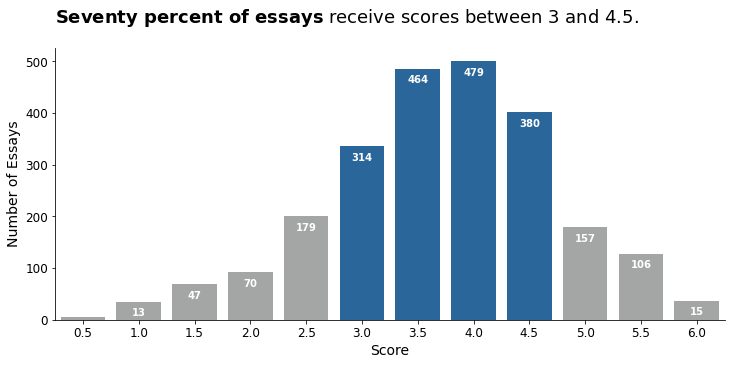

In [16]:
plt.figure(figsize=(12,5))
ax = sns.barplot(x='Score',y='Number of Essays',palette=custom_palette,data=score_counts)
title_text = r"$\bf{" 'Seventy \ percent \ of \ essays' "}$" + " receive scores between 3 and 4.5."

# Creating data labels
for p in ax.patches:
    height = (p.get_height() - 22)
    width = p.get_width()
    ax.annotate(f'{height:.0f}', (p.get_x() + width/2, height), ha='center', va='center', color='white', weight='bold')

# Formatting labels and ticks and despining
plt.title(title_text, loc='left', pad=25, fontsize= 18)
plt.xlabel('Score', fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel('Number of Essays', fontsize=14)
plt.yticks(fontsize=12)
sns.despine()
plt.show();

## 2. Preparing for Modeling

Preprocessing the data requires aggregating as much information as possible from the 8+ million logs into a form that will be useable with the essay scores. As noted above in the description, there are many opportunities for feature engineering. In the following section, I develop a preprocessing function one category at a time to preprocess unseen data from the test set for modeling.

In [17]:
full_df = train_scores_df.copy()

### 2a. Action Time

In [18]:
# Creating a variable for the sum of all action time

action_time_df = train_df.groupby(by='id')['action_time'].agg(['sum','mean','std','min','max']).reset_index()
action_time_df

,id,sum,mean,std,min,max
0,001519c8,297243,116.246774,91.797374,0,2259
1,0022f953,275391,112.221271,55.431189,0,1758
2,0042269b,421201,101.837766,82.383766,0,3005
3,0059420b,189596,121.848329,113.768226,0,806
4,0075873a,313702,123.943896,62.082013,0,701
...,...,...,...,...,...,...
2466,ffb8c745,499670,105.437856,63.622575,0,3323
2467,ffbef7e5,214221,82.266129,36.178818,0,1144
2468,ffccd6fd,231580,75.605615,63.494975,0,564
2469,ffec5b38,289439,89.277915,54.515788,0,1388


In [19]:
# Turning the Series into a DataFrame

action_time_df.columns = ['id', 'sum_action_time', 'mean_action_time', 'std_action_time', 'min_action_time', 'max_action_time']
action_time_df

,id,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time
0,001519c8,297243,116.246774,91.797374,0,2259
1,0022f953,275391,112.221271,55.431189,0,1758
2,0042269b,421201,101.837766,82.383766,0,3005
3,0059420b,189596,121.848329,113.768226,0,806
4,0075873a,313702,123.943896,62.082013,0,701
...,...,...,...,...,...,...
2466,ffb8c745,499670,105.437856,63.622575,0,3323
2467,ffbef7e5,214221,82.266129,36.178818,0,1144
2468,ffccd6fd,231580,75.605615,63.494975,0,564
2469,ffec5b38,289439,89.277915,54.515788,0,1388


In [20]:
# Calculating time given for assignment in milliseconds

30 * 60 * 1000

1800000

In [21]:
# Translating the milliseconds into seconds for interpretability

action_time_df['action_time_%_total'] = action_time_df['sum_action_time'] / 1800000

In [22]:
action_time_df.sort_values(by = 'action_time_%_total')

,id,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total
1562,a50ad9b8,13452,8.423294,38.642843,0,673,0.007473
851,5a3f0d07,17541,66.950382,22.354027,23,208,0.009745
1735,b61221f1,19629,14.131749,24.191105,0,172,0.010905
295,1dc5440c,27303,15.442873,38.582878,0,498,0.015168
1416,95acfe17,27858,65.241218,23.281103,7,269,0.015477
...,...,...,...,...,...,...,...
2018,d3fef198,950927,73.852672,37.220109,0,882,0.528293
2420,fb2cb7e6,951659,129.301495,113.117859,0,3716,0.528699
500,347a3473,959581,117.179265,44.476954,0,569,0.533101
1640,ad5f7cbb,1043640,194.781635,243.665571,0,9999,0.579800


The lowest action time was 13 seconds and the highest was 1210 seconds, or about 20 minutes. Action time measures the full duration between down event and up event. It is not a complete measure of overall productivity, but it should at least generally point towards how active each essay writer was.

In [23]:
# Merging the new features into full_df

full_df = pd.merge(full_df, action_time_df, on='id')

In [24]:
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279
...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799


### 2b. Word Count

For the word count category, I start by finding the index for the final record for each essay and taking the word count. Then, I calculate the overall words produced and create a ratio to point towards the amount of revision that occured.

In [25]:
# Finding the final word count for each essay

final_word_count = train_df.groupby('id')['word_count'].last()

In [26]:
final_word_count

id
001519c8    255
0022f953    320
0042269b    404
0059420b    206
0075873a    252
           ... 
ffb8c745    273
ffbef7e5    438
ffccd6fd    201
ffec5b38    413
fff05981    240
Name: word_count, Length: 2471, dtype: int64

In [27]:
# Turning the Series into a DataFrame

word_count_df = pd.DataFrame({'id':final_word_count.index,'word_count':final_word_count.values})

Now, I calculate the overall words produced for each essay.

In [28]:
# Finding the final event id for each essay

final_record_id_series = train_df.groupby('id')['event_id'].last()
final_record_ids = final_record_id_series.to_dict()

In [29]:
# Calculating total words for each group

def total_words(group):
    
    # Get the final record ID for each group
    final_record_id = final_record_ids[group.name]
    
    # Calculating the overall word count increase
    word_counts = group[group['event_id'] <= final_record_id]['word_count']
    word_diffs = word_counts.diff().where(lambda x: x > 0).sum()  
    
    return word_diffs

In [30]:
# Applying the function to calculate total word count for each essay

total_words = train_df.groupby('id').apply(total_words)
total_words

id
001519c8    348.0
0022f953    369.0
0042269b    549.0
0059420b    244.0
0075873a    339.0
            ...  
ffb8c745    620.0
ffbef7e5    450.0
ffccd6fd    213.0
ffec5b38    472.0
fff05981    408.0
Length: 2471, dtype: float64

In [31]:
# Merging total words into word count df

total_words_df = pd.DataFrame({'id':total_words.index,'total_words':total_words.values})
word_count_df = pd.merge(word_count_df, total_words_df, on='id')
word_count_df

,id,word_count,total_words
0,001519c8,255,348.0
1,0022f953,320,369.0
2,0042269b,404,549.0
3,0059420b,206,244.0
4,0075873a,252,339.0
...,...,...,...
2466,ffb8c745,273,620.0
2467,ffbef7e5,438,450.0
2468,ffccd6fd,201,213.0
2469,ffec5b38,413,472.0


Finally, I calculate a ratio of the word_count relative to the total words produced. This should point towards how much revision happened during the writing process.

In [32]:
word_count_df['word_count_%_total'] = word_count_df['word_count'] / word_count_df['total_words']

In [33]:
word_count_df.sort_values(by='word_count_%_total')

,id,word_count,total_words,word_count_%_total
1760,b8a857fc,409,1950.0,0.209744
784,52bec922,122,473.0,0.257928
1685,b1789fc6,212,811.0,0.261406
1264,84957285,266,960.0,0.277083
838,581eaf19,202,664.0,0.304217
...,...,...,...,...
1021,6b0cfb58,584,589.0,0.991511
925,62b9a12b,563,566.0,0.994700
2313,f08f6465,204,205.0,0.995122
1773,ba001912,259,260.0,0.996154


The essay with the lowest ratio of final word count to total words cut about 80% of the overall words that the author produced during the writing time. On the other end of the data, a few authors cut only a single word for their final pieces.

In [34]:
# Merging into the full dataframe

full_df = pd.merge(full_df,word_count_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,word_count_%_total
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,0.732759
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,0.867209
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,0.735883
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,0.844262
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,0.743363
...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,0.440323
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,0.973333
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,0.943662
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,0.875000


### 2c. Event Count

For event count, I find the final event count for each essay.

In [35]:
event_count = train_df.groupby('id')['event_id'].last()

In [36]:
event_count_df = pd.DataFrame({'id':event_count.index,'event_count':event_count.values})

In [37]:
full_df = pd.merge(full_df,event_count_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,word_count_%_total,event_count
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,0.732759,2557
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,0.867209,2454
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,0.735883,4136
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,0.844262,1556
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,0.743363,2531
...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,0.440323,4739
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,0.973333,2604
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,0.943662,3063
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,0.875000,3242


### 2d. Activity

For activity, there is some data cleaning to do around the move activities. Then, I calculate how many events are dedicated to each activity as well as a ratio of the number of events per activity relative to the total event count.

In [38]:
train_df['activity'].value_counts()

Input                                     6726796
Remove/Cut                                 970158
Nonproduction                              703851
Replace                                      4448
Paste                                         599
Move From [1306, 1371] To [1061, 1126]          2
Move From [0, 158] To [234, 392]                1
Move From [460, 461] To [465, 466]              1
Move From [134, 169] To [122, 157]              1
Move From [0, 1] To [590, 591]                  1
Move From [13, 65] To [9, 61]                   1
Move From [623, 632] To [624, 633]              1
Move From [0, 75] To [1, 76]                    1
Move From [61, 136] To [0, 75]                  1
Move From [51, 86] To [109, 144]                1
Move From [274, 314] To [299, 339]              1
Move From [1144, 1147] To [1142, 1145]          1
Move From [1651, 1769] To [1565, 1683]          1
Move From [460, 465] To [925, 930]              1
Move From [1361, 1362] To [1358, 1359]          1


In [39]:
# Cleaning the different kinds of Move events

train_df.loc[train_df['activity'].str.contains('From',case=False), 'activity'] = 'Move'

In [40]:
train_df['activity'].value_counts()

Input            6726796
Remove/Cut        970158
Nonproduction     703851
Replace             4448
Paste                599
Move                  46
Name: activity, dtype: int64

In [41]:
# Finding the counts for each activity type

activity_df = train_df.groupby(by='id')['activity'].value_counts().unstack(fill_value=0)

In [42]:
activity_df

activity,Input,Move,Nonproduction,Paste,Remove/Cut,Replace
id,,,,,,
001519c8,2010,3,120,0,417,7
0022f953,1938,0,254,1,260,1
0042269b,3515,0,175,0,439,7
0059420b,1304,0,99,1,151,1
0075873a,1942,0,72,0,517,0
...,...,...,...,...,...,...
ffb8c745,3588,0,189,0,960,2
ffbef7e5,2395,0,148,0,60,1
ffccd6fd,2849,0,126,0,88,0


In [43]:
activity_df['id'] = activity_df.index

In [44]:
activity_df.reset_index(drop=True,inplace=True)

In [45]:
# Merging with the full dataframe

full_df = pd.merge(full_df,activity_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,word_count_%_total,event_count,Input,Move,Nonproduction,Paste,Remove/Cut,Replace
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,0.732759,2557,2010,3,120,0,417,7
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,0.867209,2454,1938,0,254,1,260,1
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,0.735883,4136,3515,0,175,0,439,7
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,0.844262,1556,1304,0,99,1,151,1
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,0.743363,2531,1942,0,72,0,517,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,0.440323,4739,3588,0,189,0,960,2
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,0.973333,2604,2395,0,148,0,60,1
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,0.943662,3063,2849,0,126,0,88,0
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,0.875000,3242,2895,0,71,0,276,0


In [46]:
# Calculating ratios

full_df['Move_Ratio'] = full_df['Move'] / full_df['event_count']
full_df['Paste_Ratio'] = full_df['Paste'] / full_df['event_count']
full_df['Replace_Ratio'] = full_df['Replace'] / full_df['event_count']
full_df['Nonproduction_Ratio'] = full_df['Nonproduction'] / full_df['event_count']
full_df['Remove_Ratio'] = full_df['Remove/Cut'] / full_df['event_count']
full_df['Input_Ratio'] = full_df['Input'] / full_df['event_count']

In [47]:
# Calculating action time for each activity type

pivot = train_df.pivot_table(values='action_time', index='id', columns='activity', aggfunc=['sum']).fillna(0)

In [48]:
pivot.columns = pivot.columns.droplevel(level=0)
new_columns = [col + '_time' for col in pivot.columns]
pivot.columns = new_columns
pivot['id'] = pivot.index
pivot.reset_index(drop=True,inplace=True)
pivot

,Input_time,Move_time,Nonproduction_time,Paste_time,Remove/Cut_time,Replace_time,id
0,243731.0,0.0,18506.0,0.0,34130.0,876.0,001519c8
1,237891.0,0.0,13781.0,71.0,23550.0,98.0,0022f953
2,353718.0,0.0,33951.0,0.0,32905.0,627.0,0042269b
3,167790.0,0.0,3062.0,160.0,18410.0,174.0,0059420b
4,266515.0,0.0,6988.0,0.0,40199.0,0.0,0075873a
...,...,...,...,...,...,...,...
2466,426990.0,0.0,5203.0,0.0,67253.0,224.0,ffb8c745
2467,203403.0,0.0,6583.0,0.0,4118.0,117.0,ffbef7e5
2468,214677.0,0.0,10232.0,0.0,6671.0,0.0,ffccd6fd
2469,263216.0,0.0,5624.0,0.0,20599.0,0.0,ffec5b38


In [49]:
full_df=pd.merge(full_df,pivot,on='id')

In [50]:
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,...,Replace_Ratio,Nonproduction_Ratio,Remove_Ratio,Input_Ratio,Input_time,Move_time,Nonproduction_time,Paste_time,Remove/Cut_time,Replace_time
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,...,0.002738,0.046930,0.163082,0.786077,243731.0,0.0,18506.0,0.0,34130.0,876.0
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,...,0.000407,0.103504,0.105949,0.789731,237891.0,0.0,13781.0,71.0,23550.0,98.0
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,...,0.001692,0.042311,0.106141,0.849855,353718.0,0.0,33951.0,0.0,32905.0,627.0
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,...,0.000643,0.063625,0.097044,0.838046,167790.0,0.0,3062.0,160.0,18410.0,174.0
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,...,0.000000,0.028447,0.204267,0.767286,266515.0,0.0,6988.0,0.0,40199.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,...,0.000422,0.039882,0.202574,0.757122,426990.0,0.0,5203.0,0.0,67253.0,224.0
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,...,0.000384,0.056836,0.023041,0.919739,203403.0,0.0,6583.0,0.0,4118.0,117.0
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,...,0.000000,0.041136,0.028730,0.930134,214677.0,0.0,10232.0,0.0,6671.0,0.0
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,...,0.000000,0.021900,0.085133,0.892967,263216.0,0.0,5624.0,0.0,20599.0,0.0


In [51]:
# Calculating ratios

full_df['Move_Ratio'] = full_df['Move'] / full_df['event_count']
full_df['Paste_Ratio'] = full_df['Paste'] / full_df['event_count']
full_df['Replace_Ratio'] = full_df['Replace'] / full_df['event_count']
full_df['Nonproduction_Ratio'] = full_df['Nonproduction'] / full_df['event_count']
full_df['Remove_Ratio'] = full_df['Remove/Cut'] / full_df['event_count']
full_df['Input_Ratio'] = full_df['Input'] / full_df['event_count']
full_df['revision_events'] = full_df['Move'] + full_df['Paste'] + full_df['Replace'] + full_df['Remove/Cut']
full_df['Revision_Ratio'] =  full_df['revision_events'] / full_df['event_count']

full_df['Move_Time_Ratio'] = full_df['Move_time'] / full_df['sum_action_time']
full_df['Paste_Time_Ratio'] = full_df['Paste_time'] / full_df['sum_action_time']
full_df['Replace_Time_Ratio'] = full_df['Replace_time'] / full_df['sum_action_time']
full_df['Nonproduction_Time_Ratio'] = full_df['Nonproduction_time'] / full_df['sum_action_time']
full_df['Remove_Time_Ratio'] = full_df['Remove/Cut_time'] / full_df['sum_action_time']
full_df['Input_Time_Ratio'] = full_df['Input_time'] / full_df['sum_action_time']
full_df['revision_time'] = full_df['Move_time'] + full_df['Paste_time'] + full_df['Replace_time'] + full_df['Remove/Cut_time']
full_df['Revision_Time_Ratio'] =  full_df['revision_time'] / full_df['sum_action_time']

### 2e. Time of First Input

For this field, I identify the time of the first and last inputs to see how much time each writer takes before getting started as well as how much time each author leaves on the clock at the end.

In [52]:
# Finding first input records for each essay

first_input = train_df[train_df['activity'] == 'Input'].groupby('id').first()

In [53]:
# Creating first input dataframe

first_input_df = pd.DataFrame({'id':first_input.index,'first_input':first_input['down_time']})

In [54]:
first_input_df.reset_index(drop=True,inplace=True)

In [55]:
first_input_df

,id,first_input
0,001519c8,106686
1,0022f953,32706
2,0042269b,21335
3,0059420b,161494
4,0075873a,94454
...,...,...
2466,ffb8c745,28030
2467,ffbef7e5,40574
2468,ffccd6fd,39919
2469,ffec5b38,27617


In [56]:
# Finding last input records for each essay

last_input = train_df[train_df['activity'] == 'Input'].groupby('id').last()

In [57]:
# Creating last input dataframe

last_input_df = pd.DataFrame({'id':last_input.index,'last_input':last_input['up_time']})

In [58]:
last_input_df.reset_index(drop=True,inplace=True)

In [59]:
# Merging first and last input dfs

first_last_input_df = pd.merge(first_input_df,last_input_df,on='id')

first_last_input_df = pd.merge(first_input_df,last_input_df,on='id')

In [60]:
# Merging with full df

full_df = pd.merge(full_df,first_last_input_df, on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,...,Move_Time_Ratio,Paste_Time_Ratio,Replace_Time_Ratio,Nonproduction_Time_Ratio,Remove_Time_Ratio,Input_Time_Ratio,revision_time,Revision_Time_Ratio,first_input,last_input
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,...,0.000000,0.000000,0.002947,0.062259,0.114822,0.819972,35006.0,0.117769,106686,1782985
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,...,0.000000,0.000258,0.000356,0.050042,0.085515,0.863830,23719.0,0.086128,32706,1612149
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,...,0.000000,0.000000,0.001489,0.080605,0.078122,0.839784,33532.0,0.079610,21335,1769786
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,...,0.000000,0.000844,0.000918,0.016150,0.097101,0.884987,18744.0,0.098863,161494,1404469
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,...,0.000000,0.000000,0.000000,0.022276,0.128144,0.849580,40199.0,0.128144,94454,1662472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,...,0.000000,0.000000,0.000448,0.010413,0.134595,0.854544,67477.0,0.135043,28030,1602991
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,...,0.000000,0.000000,0.000546,0.030730,0.019223,0.949501,4235.0,0.019769,40574,1799174
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,...,0.000000,0.000000,0.000000,0.044183,0.028806,0.927010,6671.0,0.028806,39919,1959363
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,...,0.000000,0.000000,0.000000,0.019431,0.071169,0.909401,20599.0,0.071169,27617,1473899


### 2f. Input Types

Input creates a challenge because there are over 100 types of inputs, many of which occur very rarely. I focus on the input types that occur at least 100 times.

In [61]:
# Checking for the different input types

train_df['down_event'].unique()

array(['Leftclick', 'Shift', 'q', 'Space', 'Backspace', '.', ',', 'Enter',
       'ArrowLeft', "'", ';', 'ArrowRight', '-', '?', 'Tab', '"',
       'ArrowUp', 'ArrowDown', 'Rightclick', '=', 'CapsLock', 'Control',
       'c', 'v', '/', 'Delete', ':', 'z', '[', '$', '(', ')', '+', 'Home',
       'End', '\\', 'Meta', '*', '&', 'AudioVolumeMute', 'x', '!',
       'Insert', 'MediaPlayPause', 'NumLock', '%', 'V', '>', 'Alt',
       'AudioVolumeUp', 'ContextMenu', 'AudioVolumeDown', 'a', '<',
       'PageDown', ']', 'Middleclick', '@', 'F12', 'j', '\x96', 'Dead',
       't', 's', 'n', 'y', '{', 'ScrollLock', '¿', 'Process', '}',
       'MediaTrackPrevious', 'MediaTrackNext', 'F3', '^', 'Unidentified',
       'Cancel', '2', 'i', 'd', 'r', 'e', '`', '\x9b', 'm', '#', '~',
       'PageUp', 'T', 'A', 'b', 'S', 'ModeChange', '_', 'Escape', 'F11',
       'Unknownclick', 'AltGraph', 'F10', 'h', 'F15', 'Clear', 'OS', 'F',
       'C', 'o', 'Ä±', 'f', 'u', 'w', 'p', 'g', 'M', 'l', '|',
       'â\x80\x

In [62]:
# Checking how often each type occurs

train_df['down_event'].value_counts().head(25)

q               5365319
Space           1207128
Backspace        964089
Shift            334227
ArrowRight       121338
Leftclick         91126
ArrowLeft         63217
.                 59586
,                 46806
ArrowDown         30874
ArrowUp           28189
Enter             22689
CapsLock          12568
'                 11170
Delete            10965
Unidentified       6151
Control            4885
"                  4102
-                  3843
?                  3155
;                  1785
=                  1155
Tab                1081
/                   874
Rightclick          655
Name: down_event, dtype: int64

In [63]:
# Creating a variable to store the value counts

down_event_val_cnts = train_df['down_event'].value_counts()

In [64]:
# Filtering the counts to focus on events that occur at least 5 times

filtered_counts = down_event_val_cnts[down_event_val_cnts > 5]

In [65]:
len(filtered_counts)

90

In [66]:
# Converting the counts to a list of column names

target_columns = filtered_counts.index.to_list()
target_columns

['q',
 'Space',
 'Backspace',
 'Shift',
 'ArrowRight',
 'Leftclick',
 'ArrowLeft',
 '.',
 ',',
 'ArrowDown',
 'ArrowUp',
 'Enter',
 'CapsLock',
 "'",
 'Delete',
 'Unidentified',
 'Control',
 '"',
 '-',
 '?',
 ';',
 '=',
 'Tab',
 '/',
 'Rightclick',
 ':',
 '(',
 ')',
 '\\',
 'ContextMenu',
 'End',
 '!',
 'Meta',
 'Alt',
 '[',
 'c',
 'v',
 'NumLock',
 'Insert',
 'Home',
 'z',
 'AudioVolumeDown',
 'F2',
 'a',
 'x',
 'AudioVolumeUp',
 '$',
 '>',
 ']',
 '*',
 '%',
 '&',
 'Dead',
 's',
 'Escape',
 'ModeChange',
 'F3',
 '<',
 'AudioVolumeMute',
 '+',
 'F15',
 'ScrollLock',
 'Process',
 'PageDown',
 't',
 'i',
 '_',
 'PageUp',
 '`',
 '{',
 '#',
 '0',
 'Middleclick',
 '1',
 '5',
 'F12',
 '\x97',
 'OS',
 '@',
 'e',
 'F11',
 'r',
 'MediaTrackNext',
 'y',
 'm',
 'n',
 'b',
 'Clear',
 'MediaPlayPause',
 'o']

In [67]:
down_event_df = train_df.groupby(by='id')['down_event'].value_counts().unstack(fill_value=0)

In [68]:
# Filtering the dataframe for the selected columns

down_event_df = down_event_df[target_columns]

In [69]:
# Cleaning the dataframe for the merge

down_event_df['id'] = down_event_df.index
down_event_df.reset_index(drop=True,inplace=True)

In [70]:
full_df = pd.merge(full_df,down_event_df,on='id')
full_df

,id,score,sum_action_time,mean_action_time,std_action_time,min_action_time,max_action_time,action_time_%_total,word_count,total_words,...,F11,r,MediaTrackNext,y,m,n,b,Clear,MediaPlayPause,o
0,001519c8,3.5,297243,116.246774,91.797374,0,2259,0.165135,255,348.0,...,0,0,0,0,0,0,0,0,0,0
1,0022f953,3.5,275391,112.221271,55.431189,0,1758,0.152995,320,369.0,...,0,0,0,0,0,0,0,0,0,0
2,0042269b,6.0,421201,101.837766,82.383766,0,3005,0.234001,404,549.0,...,0,0,0,0,0,0,0,0,0,0
3,0059420b,2.0,189596,121.848329,113.768226,0,806,0.105331,206,244.0,...,0,0,0,0,0,0,0,0,0,0
4,0075873a,4.0,313702,123.943896,62.082013,0,701,0.174279,252,339.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,ffb8c745,3.5,499670,105.437856,63.622575,0,3323,0.277594,273,620.0,...,0,0,0,0,0,0,0,0,0,0
2467,ffbef7e5,4.0,214221,82.266129,36.178818,0,1144,0.119012,438,450.0,...,0,0,0,0,0,0,0,0,0,0
2468,ffccd6fd,1.5,231580,75.605615,63.494975,0,564,0.128656,201,213.0,...,0,0,0,0,0,0,0,0,0,0
2469,ffec5b38,5.0,289439,89.277915,54.515788,0,1388,0.160799,413,472.0,...,0,0,0,0,0,0,0,0,0,0


### 2g. Pauses

I count pauses as events between down events lasting 5 seconds or more. I create features for the number of pauses and the total time spent on pauses.

In [71]:
# Creating a function to include a feature for the previous downtime

def add_previous_down_time(group):
    group['previous_down_time'] = group['down_time'].shift(1).fillna(group['down_time'])
    return group[['id','down_time','previous_down_time']]

In [72]:
# Applying the function to each essay

pause_df = train_df.groupby('id').apply(add_previous_down_time)

In [73]:
pause_df['down_time_difference'] = pause_df['down_time'] - pause_df['previous_down_time']
pause_df['pauses'] = 0
pause_df.loc[pause_df['down_time_difference']>=5000,'pauses'] = 1

In [74]:
pause_df['pause_time'] = 0
pause_df.loc[pause_df['down_time_difference']>=5000,'pause_time'] = pause_df['down_time_difference']

In [75]:
pause_df = pause_df.reset_index(drop=True)
pause_df = pause_df[['id','pauses','pause_time']]
pause_df = pause_df.groupby('id').sum()

In [76]:
pause_df

,pauses,pause_time
id,,
001519c8,64,990349.0
0022f953,47,1078925.0
0042269b,34,984197.0
0059420b,30,600419.0
0075873a,49,922116.0
...,...,...
ffb8c745,24,920566.0
ffbef7e5,42,821360.0
ffccd6fd,34,980387.0


In [77]:
pause = pause_df.groupby(by='id')
pause_features = pause.agg({
        'pauses': ['sum'], 
        'pause_time': ['sum', 'mean', 'min', 'max'],                                           
    })

In [78]:
pause_features.columns = ['_'.join(col).strip() for col in pause_features.columns.values]

In [79]:
pause_features.reset_index(inplace=True)
pause_features

,id,pauses_sum,pause_time_sum,pause_time_mean,pause_time_min,pause_time_max
0,001519c8,64,990349.0,990349.0,990349.0,990349.0
1,0022f953,47,1078925.0,1078925.0,1078925.0,1078925.0
2,0042269b,34,984197.0,984197.0,984197.0,984197.0
3,0059420b,30,600419.0,600419.0,600419.0,600419.0
4,0075873a,49,922116.0,922116.0,922116.0,922116.0
...,...,...,...,...,...,...
2466,ffb8c745,24,920566.0,920566.0,920566.0,920566.0
2467,ffbef7e5,42,821360.0,821360.0,821360.0,821360.0
2468,ffccd6fd,34,980387.0,980387.0,980387.0,980387.0
2469,ffec5b38,30,638164.0,638164.0,638164.0,638164.0


In [80]:
full_df = pd.merge(full_df,pause_features,on='id')

In [81]:
full_df['characters_per_pause'] = full_df['q'] / full_df['pauses_sum']
full_df.loc[full_df['pauses_sum']==0,'characters_per_pause'] = full_df['q']
full_df['action_time_per_pause'] = full_df['sum_action_time'] / full_df['pauses_sum']
full_df.loc[full_df['pauses_sum']==0,'action_time_per_pause'] = full_df['sum_action_time']
full_df['action_time_per_pause_time'] = full_df['sum_action_time'] / full_df['pause_time_sum']
full_df.loc[full_df['pause_time_sum']==0,'action_time_per_pause_time'] = full_df['sum_action_time']

### 2i. Sentence Length

Now that I have all of the information from the logs that I want to use in my model in the full dataframe, I construct some additional features for the model to use. First, I approximate sentence length by dividing the final word count by the number of periods in the essay. Sentence length can indicate sophisticated sentence structure. It can also indicate run-on sentences.

In [82]:
full_df['end_punctuation'] = full_df['.'] + full_df['!'] + full_df['?']
full_df['sentence_length'] = full_df['total_words'] / full_df['end_punctuation']
full_df.loc[(full_df['end_punctuation']==0),'sentence_length'] = full_df['total_words']

In [83]:
full_df['events_per_word'] = full_df['event_count'] / full_df['word_count']
full_df.loc[full_df['word_count']==0,'events_per_word'] = full_df['event_count']

In [84]:
full_df['characters_per_word'] = full_df['q'] / full_df['total_words']
full_df.loc[full_df['total_words']==0,'characters_per_word'] = full_df['q']

In [86]:
full_df.isnull().sum().sum()

0

### 2j. Preprocessing Function

I combine all of these steps into a single function so that I can preprocess unseen data without having to repeat all of the previous steps.

In [85]:
def preprocess(log_df):
    
    # Action Time
    action_time = log_df.groupby(by='id')['action_time'].sum()
    action_time_df = pd.DataFrame({'id':action_time.index, 'action_time':action_time.values})
    action_time_df['action_time'] = action_time_df['action_time']
    action_time_df['action_time_%_total'] = action_time_df['action_time'] / 1800000
    
    # Final Word Count
    final_word_count = log_df.groupby('id')['word_count'].last()
    word_count_df = pd.DataFrame({'id':final_word_count.index,'word_count':final_word_count.values})
    final_record_id_series = log_df.groupby('id')['event_id'].last()
    final_record_ids = final_record_id_series.to_dict()
    
    def total_words(group):
        final_record_id = final_record_ids[group.name]
        word_counts = group[group['event_id'] <= final_record_id]['word_count']
        word_diffs = word_counts.diff().where(lambda x: x > 0).sum()  
    
        return word_diffs
    
    total_words = log_df.groupby('id').apply(total_words)
    total_words_df = pd.DataFrame({'id':total_words.index,'total_words':total_words.values})
    word_count_df = pd.merge(word_count_df, total_words_df, on='id')
    
    # Final Event Count
    event_count = log_df.groupby('id')['event_id'].last()
    event_count_df = pd.DataFrame({'id':event_count.index,'event_count':event_count.values})
    
    # Activity
    activities = ['Input', 'Move', 'Nonproduction', 'Paste', 'Remove/Cut', 'Replace']
    
    log_df.loc[log_df['activity'].str.contains('From',case=False), 'activity'] = 'Move'
    log_df.loc[log_df['activity'].str.contains('From',case=False), 'activity'] = 'Move'
    activity_data = log_df.groupby(by='id')['activity'].value_counts().unstack(fill_value=0)
    
    for activity in activities:
        if activity in activity_data.columns:
            activity_data[activity] = activity_data[activity]
        else:
            activity_data[activity] = 0
    
    activity_df = activity_data.reset_index(inplace=True)
    
    pivot = log_df.pivot_table(values='action_time', index='id', columns='activity', aggfunc=['sum']).fillna(0)
    pivot.columns = pivot.columns.droplevel(level=0)
    
    for activity in activities:
        if activity in pivot.columns:
            pivot[activity] = pivot[activity]
        else:
            pivot[activity] = 0
    
    new_columns = [col + '_time' for col in pivot.columns]
    pivot.columns = new_columns
    pivot.reset_index(inplace=True)
    
    # Time of First and Last Input
    first_input = log_df[log_df['activity'] == 'Input'].groupby('id').first()
    first_input_df = pd.DataFrame({'id':first_input.index,'first_input':first_input['down_time']})
    first_input_df.reset_index(drop=True,inplace=True)
    last_input = log_df[log_df['activity'] == 'Input'].groupby('id').last()
    last_input_df = pd.DataFrame({'id':last_input.index,'last_input':last_input['up_time']})
    last_input_df.reset_index(drop=True,inplace=True)
    first_last_input_df = pd.merge(first_input_df,last_input_df,on='id')
    
    # Inputs
    columns = ['q', 'Space', 'Backspace', 'Shift', 'ArrowRight', 'Leftclick', 'ArrowLeft', '.', ',',
               'ArrowDown', 'ArrowUp', 'Enter', 'CapsLock', "'", 'Delete', 'Unidentified', 'Control',
               '"', '-', '?', ';', '=', 'Tab', '/', 'Rightclick', ':', '(', ')', '\\', 'ContextMenu',
               'End', '!', 'Meta', 'Alt', '[', 'c', 'v', 'NumLock', 'Insert', 'Home', 'z', 'AudioVolumeDown',
               'F2', 'a', 'x', 'AudioVolumeUp', '$', '>', ']', '*', '%', '&', 'Dead', 's', 'Escape',
               'ModeChange', 'F3', '<', 'AudioVolumeMute', 'F15', '+', 'ScrollLock', 'Process', 'PageDown',
               't', 'i', '_', '`', 'PageUp', '{', '0', '#', 'Middleclick', '1', '5', 'F12', '\x97',
               'OS', 'e', '@', 'F11', 'r', 'MediaTrackNext', 'y', 'm', 'n', 'b', 'Clear', 'MediaPlayPause', 'o']
    
    down_event_data = log_df.groupby(by='id')['down_event'].value_counts().unstack(fill_value=0)
    
    for col in columns:
        if col in down_event_data.columns:
            down_event_data[col] = down_event_data[col]
        else:
            down_event_data[col] = 0
    
    down_event_df = down_event_data[columns]
    down_event_df.reset_index(inplace='True')
    
            
    # Pauses
    def add_previous_down_time(group):
        group['previous_down_time'] = group['down_time'].shift(1).fillna(group['down_time'])
        return group[['id','down_time','previous_down_time']]

    pause_df = log_df.groupby('id').apply(add_previous_down_time)
    
    pause_df['down_time_difference'] = pause_df['down_time'] - pause_df['previous_down_time']
    pause_df['pauses'] = 0
    pause_df.loc[pause_df['down_time_difference']>=5000,'pauses'] = 1
    
    pause_df['pause_time'] = 0
    pause_df.loc[pause_df['down_time_difference']>=5000,'pause_time'] = pause_df['down_time_difference']
    
    pause_df = pause_df.reset_index(drop=True)
    pause_df = pause_df[['id','pauses','pause_time']]
    pause_df = pause_df.groupby('id').sum()
    
    # Merge DataFrames
    full_df = pd.merge(action_time_df, word_count_df, on = 'id')
    full_df = pd.merge(full_df, pivot, on = 'id')
    full_df = pd.merge(full_df, event_count_df, on = 'id')
    full_df = pd.merge(full_df, activity_df, on = 'id')
    full_df = pd.merge(full_df, first_last_input_df, on = 'id')
    full_df = pd.merge(full_df, down_event_df, on = 'id')
    full_df = pd.merge(full_df, pause_df, on = 'id')
    
    # Sentence Length
    full_df['end_punctuation'] = full_df['.'] + full_df['!'] + full_df['?']
    full_df['sentence_length'] = full_df['word_count'] / full_df['end_punctuation']
    full_df.loc[full_df['end_punctuation']==0,'sentence_length'] = full_df['word_count']
    
    # Ratios
    full_df['Move_Ratio'] = full_df['Move'] / full_df['event_count']
    full_df['Paste_Ratio'] = full_df['Paste'] / full_df['event_count']
    full_df['Replace_Ratio'] = full_df['Replace'] / full_df['event_count']
    full_df['Nonproduction_Ratio'] = full_df['Nonproduction'] / full_df['event_count']
    full_df['Remove_Ratio'] = full_df['Remove/Cut'] / full_df['event_count']
    full_df['Input_Ratio'] = full_df['Input'] / full_df['event_count']
    full_df['revision_events'] = full_df['Move'] + full_df['Paste'] + full_df['Replace'] + full_df['Remove/Cut']
    full_df['Revision_Ratio'] =  full_df['revision_events'] / full_df['event_count']
    full_df['characters_per_pause'] = full_df['q'] / full_df['pauses']
    full_df.loc[full_df['pauses']==0,'characters_per_pause'] = full_df['q']
    full_df['Move_Time_Ratio'] = full_df['Move_time'] / full_df['action_time']
    full_df['Paste_Time_Ratio'] = full_df['Paste_time'] / full_df['action_time']
    full_df['Replace_Time_Ratio'] = full_df['Replace_time'] / full_df['action_time']
    full_df['Nonproduction_Time_Ratio'] = full_df['Nonproduction_time'] / full_df['action_time']
    full_df['Remove_Time_Ratio'] = full_df['Remove/Cut_time'] / full_df['action_time']
    full_df['Input_Time_Ratio'] = full_df['Input_time'] / full_df['action_time']
    full_df['revision_time'] = full_df['Move_time'] + full_df['Paste_time'] + full_df['Replace_time'] + full_df['Remove/Cut_time']
    full_df['Revision_Time_Ratio'] =  full_df['revision_time'] / full_df['action_time']
    full_df['action_time_per_pause'] = full_df['action_time'] / full_df['pauses']
    full_df.loc[full_df['pauses']==0,'action_time_per_pause'] = full_df['action_time']
    full_df['action_time_per_pause_time'] = full_df['action_time'] / full_df['pause_time']
    full_df.loc[full_df['pause_time']==0,'action_time_per_pause_time'] = full_df['action_time']
    
    return full_df